In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

Home Team - Initial Fatigue: 0.327, Starting Rhythm: 1.000
Away Team - Initial Fatigue: 0.041, Starting Rhythm: 0.881


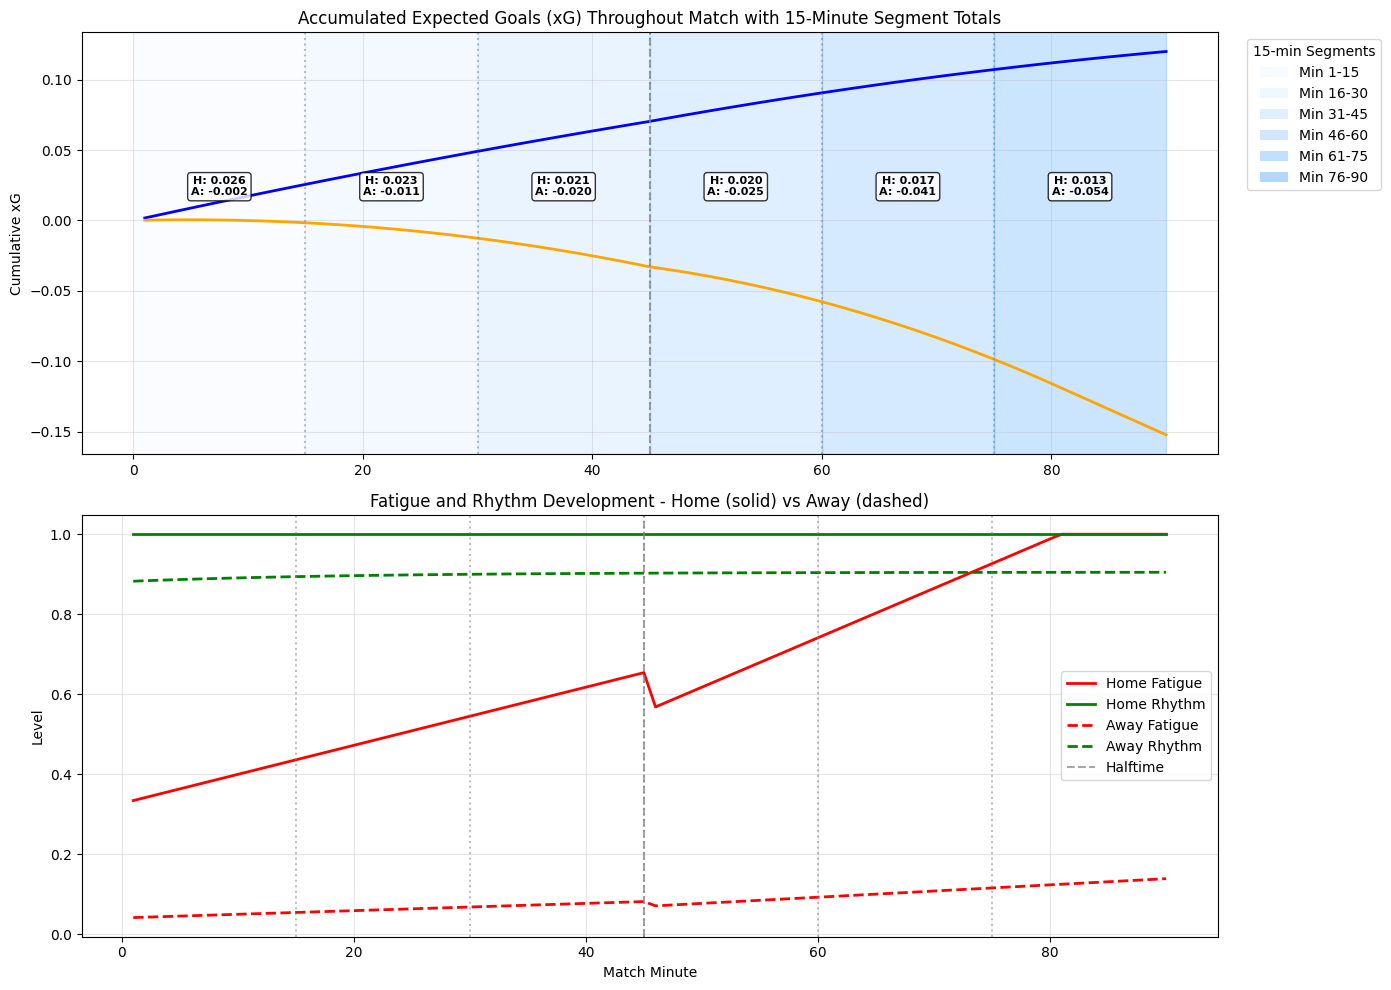


Final Cumulative Home xG: 0.120
Final Cumulative Away xG: -0.152

15-Minute Segment Analysis:
Segment | Minutes  | Home xG   | Away xG   | Total xG  
-------------------------------------------------------
      1 |  1-15    | 0.026     | -0.002     | 0.024
      2 | 16-30    | 0.023     | -0.011     | 0.013
      3 | 31-45    | 0.021     | -0.020     | 0.001
      4 | 46-60    | 0.020     | -0.025     | -0.005
      5 | 61-75    | 0.017     | -0.041     | -0.024
      6 | 76-90    | 0.013     | -0.054     | -0.041

Team Analysis:
Fatigue Home: 0.327 vs Away: 0.041
(Rhythm Home: 1.000 vs Away: 0.881)
Original Home: 2.5999999999999996 vs Away: 1.5)


In [ ]:
# Calculate initial fatigue and rhythm based on DIFFERENT recent matches for each team
home_matches = [
    (45, 3),   
    (90, 7),   
    (90, 10), 
    (90, 14),  
    (90, 21),  
    (90, 28),  
    (90, 35),  
    (90, 42),  
    (90, 48),  
]

away_matches = [
    (90, 10),   
    (45, 14),   
    (45, 21),
    (45, 28),  
    (45, 40), 
]

# Fatigue calculation (3-day decay)
home_total_decayed_minutes_fatigue = sum(minutes * math.exp(-days / 3) for minutes, days in home_matches)
home_initial_fatigue = min(1, home_total_decayed_minutes_fatigue / 90)

away_total_decayed_minutes_fatigue = sum(minutes * math.exp(-days / 3) for minutes, days in away_matches)
away_initial_fatigue = min(1, away_total_decayed_minutes_fatigue / 90)

# Rhythm calculation (14-day decay)
home_total_decayed_minutes_rhythm = sum(minutes * math.exp(-days / 14) for minutes, days in home_matches)
home_rhythm_start = min(1, home_total_decayed_minutes_rhythm / 90)

away_total_decayed_minutes_rhythm = sum(minutes * math.exp(-days / 14) for minutes, days in away_matches)
away_rhythm_start = min(1, away_total_decayed_minutes_rhythm / 90)

print(f"Home Team - Initial Fatigue: {home_initial_fatigue:.3f}, Starting Rhythm: {home_rhythm_start:.3f}")
print(f"Away Team - Initial Fatigue: {away_initial_fatigue:.3f}, Starting Rhythm: {away_rhythm_start:.3f}")

# Simulation parameters for BOTH teams
# Home team parameters 
home_base_off_raxg = 1.4  # Home base offensive expected goals per match
home_base_def_raxg = 0.65  # Home base defensive expected goals conceded per match

# Away team parameters 
away_base_off_raxg = 0.85  # Away base offensive expected goals per match
away_base_def_raxg = 1.2  # Away base defensive expected goals conceded per match

# Shared parameters
max_fatigue_increase = 1
improvement_rate = 0.2
tau_inmatch = 20
omega = 0.80
halftime_recovery_factor = 0.85

# Initialize arrays to store values for each minute
minutes = list(range(1, 91))

# Home team arrays
home_fatigue = [0] * 90
home_rhythm = [0] * 90
home_effective_off_raxg = [0] * 90
home_effective_def_raxg = [0] * 90

# Away team arrays
away_fatigue = [0] * 90
away_rhythm = [0] * 90
away_effective_off_raxg = [0] * 90
away_effective_def_raxg = [0] * 90

# Combined xG arrays
home_xg_per_minute = [0] * 90
away_xg_per_minute = [0] * 90
cumulative_home_xg = [0] * 90
cumulative_away_xg = [0] * 90

# Calculate values for each minute for BOTH teams
for t in range(90):
    current_minute = t + 1
    
    # HOME TEAM CALCULATIONS
    # Fatigue calculation
    if current_minute <= 45:
        # First half fatigue accumulation
        fatigue_increase = (current_minute / 45) * max_fatigue_increase * home_initial_fatigue
        home_fatigue[t] = min(1.0, home_initial_fatigue + fatigue_increase)
    else:
        # Apply halftime recovery
        if current_minute == 46:
            fatigue_at_45_home = home_initial_fatigue + max_fatigue_increase * home_initial_fatigue
            fatigue_after_halftime_home = fatigue_at_45_home * halftime_recovery_factor
        
        # Second half fatigue accumulation (using recovered fatigue as new baseline)
        fatigue_increase_2nd = ((current_minute - 45) / 45) * max_fatigue_increase * fatigue_after_halftime_home
        home_fatigue[t] = min(1.0, fatigue_after_halftime_home + fatigue_increase_2nd)
    
    # Rhythm improvement
    home_rhythm[t] = home_rhythm_start + (1 - home_rhythm_start) * improvement_rate * (1 - math.exp(-current_minute / tau_inmatch))
    
    # Apply performance model
    home_effective_off_raxg[t] = home_base_off_raxg * (0.9 + 0.1 * home_rhythm[t])
    home_effective_def_raxg[t] = home_base_def_raxg * (1 - omega * home_fatigue[t])
    
    # AWAY TEAM CALCULATIONS (using away team's own fatigue/rhythm starting points)
    if current_minute <= 45:
        fatigue_increase = (current_minute / 45) * max_fatigue_increase * away_initial_fatigue
        away_fatigue[t] = min(1.0, away_initial_fatigue + fatigue_increase)
    else:
        if current_minute == 46:
            fatigue_at_45_away = away_initial_fatigue + max_fatigue_increase * away_initial_fatigue
            fatigue_after_halftime_away = fatigue_at_45_away * 0.85
        
        fatigue_increase_2nd = ((current_minute - 45) / 45) * max_fatigue_increase * fatigue_after_halftime_away
        away_fatigue[t] = min(1.0, fatigue_after_halftime_away + fatigue_increase_2nd)
    
    away_rhythm[t] = away_rhythm_start + (1 - away_rhythm_start) * improvement_rate * (1 - math.exp(-current_minute / tau_inmatch))
    
    away_effective_off_raxg[t] = away_base_off_raxg * (0.9 + 0.1 * away_rhythm[t])
    away_effective_def_raxg[t] = away_base_def_raxg * (1 - omega * away_fatigue[t])
    
    # COMBINED xG CALCULATION
    # Home xG = home offensive capability + away defensive weakness
    home_xg_this_minute = (home_effective_off_raxg[t] - away_effective_def_raxg[t]) / 90
    # Away xG = away offensive capability + home defensive weakness  
    away_xg_this_minute = (away_effective_off_raxg[t] - home_effective_def_raxg[t]) / 90
    
    home_xg_per_minute[t] = home_xg_this_minute
    away_xg_per_minute[t] = away_xg_this_minute
    
    # Calculate cumulative xG
    if t == 0:
        cumulative_home_xg[t] = home_xg_this_minute
        cumulative_away_xg[t] = away_xg_this_minute
    else:
        cumulative_home_xg[t] = cumulative_home_xg[t-1] + home_xg_this_minute
        cumulative_away_xg[t] = cumulative_away_xg[t-1] + away_xg_this_minute

# Calculate 15-minute segment totals
segment_minutes = 15
num_segments = 6
segment_home_xg = [0] * num_segments
segment_away_xg = [0] * num_segments

for i in range(num_segments):
    start_min = i * segment_minutes
    end_min = (i + 1) * segment_minutes
    if i == num_segments - 1:
        end_min = 90
    
    # Calculate total xG for this segment by summing minute-by-minute values
    segment_home_xg[i] = sum(home_xg_per_minute[start_min:end_min])
    segment_away_xg[i] = sum(away_xg_per_minute[start_min:end_min])

# Create the visualization
plt.figure(figsize=(14, 10))

# Plot cumulative xG with segment background
plt.subplot(2, 1, 1)

# Add background segments
colors_home = ['#e6f2ff', '#cce5ff', '#99ccff', '#66b2ff', '#3399ff', '#0080ff']
colors_away = ['#fff0e6', '#ffe0cc', '#ffc299', '#ffa366', '#ff8533', '#ff6600']

for i in range(num_segments):
    start_min = i * segment_minutes
    end_min = (i + 1) * segment_minutes
    if i == num_segments - 1:
        end_min = 90
    
    plt.axvspan(start_min, end_min, alpha=0.2, color=colors_home[i])
    
    # Add text labels for segment xG values
    segment_center = (start_min + end_min) / 2
    plt.text(segment_center, max(cumulative_home_xg[-1], cumulative_away_xg[-1]) * 0.2, 
             f'H: {segment_home_xg[i]:.3f}\nA: {segment_away_xg[i]:.3f}', 
             ha='center', va='center', fontweight='bold', fontsize=8,
             bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# Plot the cumulative xG lines
plt.plot(minutes, cumulative_home_xg, label='Cumulative Home xG', color='blue', linewidth=2)
plt.plot(minutes, cumulative_away_xg, label='Cumulative Away xG', color='orange', linewidth=2)
plt.axvline(x=45, color='gray', linestyle='--', alpha=0.7, label='Halftime')

# Add segment divider lines
for i in range(1, num_segments):
    plt.axvline(x=i * segment_minutes, color='gray', linestyle=':', alpha=0.5)

plt.title('Accumulated Expected Goals (xG) Throughout Match with 15-Minute Segment Totals')
plt.ylabel('Cumulative xG')
plt.legend()
plt.grid(True, alpha=0.3)

# Add a legend for the segments
legend_elements = [
    Patch(facecolor=colors_home[0], alpha=0.3, label='Min 1-15'),
    Patch(facecolor=colors_home[1], alpha=0.3, label='Min 16-30'),
    Patch(facecolor=colors_home[2], alpha=0.3, label='Min 31-45'),
    Patch(facecolor=colors_home[3], alpha=0.3, label='Min 46-60'),
    Patch(facecolor=colors_home[4], alpha=0.3, label='Min 61-75'),
    Patch(facecolor=colors_home[5], alpha=0.3, label='Min 76-90')
]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), title="15-min Segments")

# Plot fatigue and rhythm for both teams
plt.subplot(2, 1, 2)
plt.plot(minutes, home_fatigue, label='Home Fatigue', color='red', linewidth=2)
plt.plot(minutes, home_rhythm, label='Home Rhythm', color='green', linewidth=2)
plt.plot(minutes, away_fatigue, label='Away Fatigue', color='red', linestyle='--', linewidth=2)
plt.plot(minutes, away_rhythm, label='Away Rhythm', color='green', linestyle='--', linewidth=2)
plt.axvline(x=45, color='gray', linestyle='--', alpha=0.7, label='Halftime')

# Add segment divider lines
for i in range(1, num_segments):
    plt.axvline(x=i * segment_minutes, color='gray', linestyle=':', alpha=0.5)

plt.title('Fatigue and Rhythm Development - Home (solid) vs Away (dashed)')
plt.xlabel('Match Minute')
plt.ylabel('Level')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final values and segment analysis
print(f"\nFinal Cumulative Home xG: {cumulative_home_xg[-1]:.3f}")
print(f"Final Cumulative Away xG: {cumulative_away_xg[-1]:.3f}")

print("\n15-Minute Segment Analysis:")
print("Segment | Minutes  | Home xG   | Away xG   | Total xG  ")
print("-" * 55)
for i in range(num_segments):
    start_min = i * segment_minutes + 1
    end_min = (i + 1) * segment_minutes
    if i == num_segments - 1:
        end_min = 90
    total_xg = segment_home_xg[i] + segment_away_xg[i]
    print(f"{i+1:7} | {start_min:2}-{end_min:2}    | {segment_home_xg[i]:.3f}     | {segment_away_xg[i]:.3f}     | {total_xg:.3f}")

# Print team analysis
print(f"\nTeam Analysis:")
print(f"Fatigue Home: {home_initial_fatigue:.3f} vs Away: {away_initial_fatigue:.3f}")
print(f"(Rhythm Home: {home_rhythm_start:.3f} vs Away: {away_rhythm_start:.3f})")
print(f"Original Home: {home_base_off_raxg + away_base_def_raxg} vs Away: {away_base_off_raxg + home_base_def_raxg})")